In [1]:
from mcsm_benchs.Benchmark import Benchmark
from mcsm_benchs.ResultsInterpreter import ResultsInterpreter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import Audio
import os


plt.rcParams['xtick.labelsize'] = 6.0
plt.rcParams['ytick.labelsize'] = 6.0
plt.rcParams['axes.labelsize'] =  6.0
plt.rc('axes', axisbelow=True)

In [2]:
filename = os.path.join('.','results','benchmark_babble')
benchmark = Benchmark.load_benchmark(filename)
df_pesq = benchmark.get_results_as_df()[0]
df_stoi = benchmark.get_results_as_df()[1] # This is STOI, just for the two speech signals.

In [3]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
interpreter = ResultsInterpreter(benchmark)
# figs = interpreter.get_summary_plotlys()
# for bars in figs:
#     iplot(bars)

In [4]:
df_pesq

,Method,Parameter,Signal_id,Repetition,-5,0,5,10,15,20
5000,dt,{'LB': 1.0},6_female,0,1.173478,1.287842,1.508739,1.865829,2.220479,2.672929
5001,dt,{'LB': 1.0},6_female,1,1.179168,1.282509,1.482635,1.768368,2.110731,2.521066
5002,dt,{'LB': 1.0},6_female,2,1.188607,1.287091,1.481186,1.756577,2.115696,2.490576
5003,dt,{'LB': 1.0},6_female,3,1.063385,1.242581,1.389616,1.654312,1.995417,2.394715
5004,dt,{'LB': 1.0},6_female,4,1.206180,1.314125,1.519449,1.834041,2.188495,2.608705
...,...,...,...,...,...,...,...,...,...,...
34395,ht,"{'coeff': 5.0, 'Nfft': 4096}",trumpet,95,1.073660,1.135269,1.246216,1.466221,2.341330,3.059503
34396,ht,"{'coeff': 5.0, 'Nfft': 4096}",trumpet,96,1.039066,1.097002,1.227380,1.524188,2.225172,2.762930
34397,ht,"{'coeff': 5.0, 'Nfft': 4096}",trumpet,97,1.066501,1.150976,1.283921,1.541487,2.318504,3.123706
34398,ht,"{'coeff': 5.0, 'Nfft': 4096}",trumpet,98,1.068060,1.133712,1.289203,1.525198,2.227289,3.111982


In [5]:
# Para cada SNR encontrar el mejor LB y el mejor threshold de HT
snr = [-5,0,5,10,15,20]
# DT parameters:
dt_p = np.unique(df_pesq['Parameter'][df_pesq['Method']=='dt'])
# Signal ids:
signal_ids = np.unique(df_pesq['Signal_id'])
# Methods:
methods = ['dt','ht']

In [6]:
# Get the best threshold for both dt and ht for each SNR to compare later.

for i,signal_id in enumerate(signal_ids):
    print(signal_id)
    df_signal = df_pesq[df_pesq['Signal_id']==signal_id]
    aux = df_signal.groupby(by=['Parameter']).mean(numeric_only=True) 
    best_lb = []
    best_coeff = []
    for j,val in enumerate(snr):
        idx_dt = [] # Indexes of dt and ht rows.
        idx_ht = []
        for p in aux.index:
            try:
                param_dict = eval(p)
                if 'LB' in param_dict:
                    idx_dt.append(True)
                    idx_ht.append(False)
                if 'coeff' in param_dict:
                    idx_dt.append(False)
                    idx_ht.append(True)
            except:
                idx_dt.append(False)
                idx_ht.append(False)
        best_lb.append(aux.index[idx_dt][np.argmax(aux[val][idx_dt])])
        best_coeff.append(aux.index[idx_ht][np.argmax(aux[val][idx_ht])])

        if j == 0:
            # First, add the dt results with the summary functions.
            df_new = df_signal[df_signal['Parameter'].isin(dt_p[-1:-4:-1])]
            # Add the results for -5 db
            df_new = pd.concat((df_new, df_signal[df_signal['Parameter']==best_lb[0]]))
            df_new = pd.concat((df_new, df_signal[df_signal['Parameter']==best_coeff[0]]))
        else:
            # Add the rest of SNR columns
            df_new.loc[df_new['Parameter']==best_lb[0],val] = df_signal.loc[df_signal['Parameter']==best_lb[j],val].values
            df_new.loc[df_new['Parameter']==best_coeff[0],val] = df_signal.loc[df_signal['Parameter']==best_coeff[j],val].values

    if i==0:
        df_best = df_new.copy()
    else:
        df_best = pd.concat((df_best,df_new))

    df_best.loc[df_best['Parameter']==best_lb[0],'Parameter'] = 'Best DT'
    df_best.loc[df_best['Parameter']==best_coeff[0],'Parameter'] = 'Best HT'
# df_best[df_best['Parameter']==best_lb[0]] == 'Best DT'

6_female
6_male
cello
trumpet


In [7]:
# Rearrange dataset for ease plotting.
df_best = df_best.melt(id_vars=['Method','Parameter','Signal_id','Repetition'], var_name='SNR', value_name='PESQ')

6_female
6_male
cello
trumpet


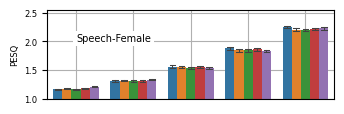

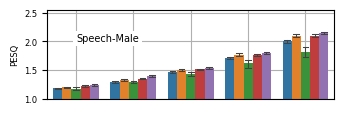

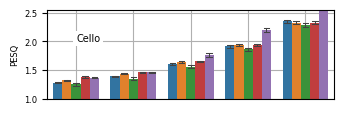

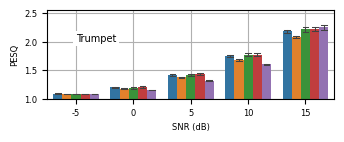

<Figure size 300x25 with 0 Axes>

In [8]:
import seaborn as sns
import scipy
comb = scipy.special.comb(5*5,2) # 5 methods x 6 value of snr. This is for the bonferroni correction.
signal_names = ['Speech-Female','Speech-Male','Cello','Trumpet']
err_kws = {'linewidth':0.75,}
for i,signal_id in enumerate(signal_ids):
    print(signal_id)
    df_signal = df_best[df_best['Signal_id']==signal_id]
    df_signal = df_signal[df_signal['SNR']<=15]
    fig, ax = plt.subplots(1,1,figsize=(3.7,1.15),)    
    barfig = sns.barplot(x="SNR", 
                        y="PESQ",
                        hue="Parameter",
                        data=df_signal, 
                        dodge=True, 
                        errorbar=('ci',(1-0.05/(comb))*100),
                        ax = ax,
                        err_kws=err_kws,
                        capsize=0.5,)
    ax.get_legend().remove() # Comment to remove legends (printed in another figure)
    ax.set_ylim([1.0,2.55])
    if i==3:
        ax.set_xlabel('SNR (dB)')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('PESQ')
    xlims = ax.get_xlim()
    # ax.plot(xlims,[4.55,4.55],'--k',linewidth=0.5)
    plt.grid(True)

    t = ax.text(0,2.0,signal_names[i],fontsize=7.0)
    t.set_bbox(dict(facecolor='white', alpha=1.0, edgecolor='none', pad=2.0))

    if i<3:
        ax.tick_params(axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False) # labels along the bottom edge are off
    
    # filename = os.path.join('.','figures','results_'+signal_id+'_denoise.pdf')
    # fig.savefig(filename,
    #         dpi=900, 
    #         transparent=False, 
    #         #  bbox_extra_artists=(axins,),
    #         bbox_inches='tight', 
    #         pad_inches=0.01) 
    

# Get legends in a different figure
legendFig = plt.figure(figsize=(3.0,0.25))
new_legends = ['APF','F','Fvs','Best DT', 'Best HT']
h,l = fig.axes[0].get_legend_handles_labels()
legendFig.legend(h, new_legends, fontsize='small', frameon=False, loc='center', ncol=8)
legendFig.canvas.draw()

# Save figure with legends
# filename = os.path.join('figures','legend_pesq.pdf')
# legendFig.savefig(filename, dpi=900, transparent=False, bbox_inches='tight')

plt.show()